In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Зададим простейшие одномерные данные:

In [2]:
data = np.array([1, -2, -3, -1, 2, 3])[:, np.newaxis]
target = np.array([0, 0, 0, 1, 1, 1])

In [6]:
data.shape

(6, 1)

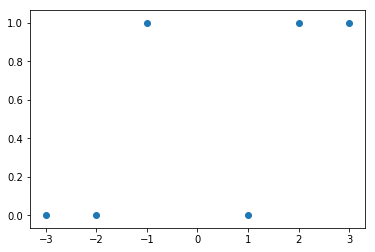

In [3]:
plt.scatter(data.ravel(), target)

Реализуем вычисление функционала качества:

In [36]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))
    
def qual(w, X, y, C=0):
    ### your code here
    ### 0, 1 -> -1, +1
    y = 2 * y - 1
    q = np.log(1+np.exp(-X.dot(w)*y)).mean()
    if C > 0:
        q += 2 / C * np.sum(w**2)
    return q

0.1 0.632296924641
1 0.496259016712
10 3.33334846699


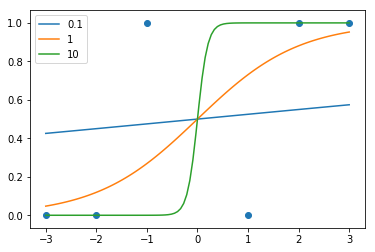

In [5]:
plt.scatter(data.ravel(), target)
ls = np.linspace(-3, 3, 100)
for w in [0.1, 1, 10]:
    print(w, qual([w], data, target))
    plt.plot(ls, sigmoid(w*ls), label=str(w))
plt.legend()

Не выгодно подгоняться под "правильные" ответы, лучше всего что-то среднее.

In [7]:
from scipy.optimize import minimize

In [37]:
def grad(w, X, y, C=0):
    ### your code here
    ### 0, 1 -> -1, +1
    y = 2 * y -1
    den = 1 + np.exp(y*X.dot(w))
    mat = - (X * y[:, np.newaxis]) / den[:, np.newaxis]
    grad = mat.mean(axis=0)
    if C > 0:
        grad += 1 / C * w
    return grad

class Callback:
    def __init__(self):
        self.ws = []
        
    def call(self, w):
        self.ws.append(np.copy(w))

class MyLR:
    def __init__(self, C=0):
        self.C = C
    
    def fit(self, X, y):
        d = X.shape[1] 
        w = np.zeros(d) #  инициализация весов
        self.callback = Callback()
        # обучение весов
        self.res = minimize(qual, w,  
                    method="L-BFGS-B",
                    jac=grad,
                    args=(X, y, self.C),
                    callback=self.callback.call)
        self.w = self.res.x
    
    def predict(self, X):
        ### your code here
        # returns 0 and 1
        return (X.dot(self.w) > 0).astype(int)
    
    def predict_proba(self, X):
        ### your code here
        # returns probabilities in [0, 1]
        return sigmoid(X.dot(self.w))

Сравним результат нашей реализации и sklearn:

In [38]:
from sklearn.linear_model import LogisticRegression as LR

In [39]:
lr = LR(C=10**8) # "no reg"
lr.fit(data, target)
lr.coef_

array([[ 0.73248745]])

In [40]:
mylr = MyLR()
mylr.fit(data, target)
mylr.w

array([ 0.73248729])

Процесс обучения весов:

In [41]:
mylr.callback.ws

[array([ 1.]),
 array([ 0.850928]),
 array([ 0.70115804]),
 array([ 0.7357471]),
 array([ 0.73257315]),
 array([ 0.73248729])]

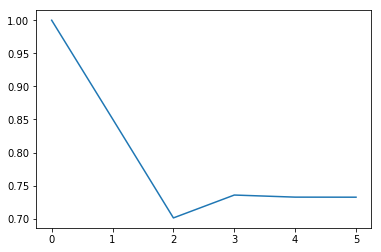

In [42]:
plt.plot(mylr.callback.ws)

Теперь посмотрим, что будет, если данные линейно разделимы:

In [43]:
data2 = np.array([-1, -2, -3, 1, 2, 3])[:, np.newaxis]
target = np.array([0, 0, 0, 1, 1, 1])

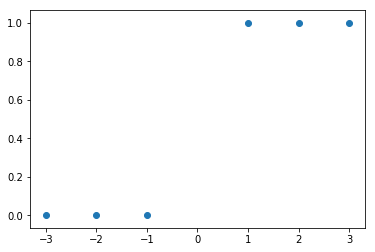

In [44]:
plt.scatter(data2.ravel(), target)

In [45]:
mylr = MyLR()
mylr.fit(data2, target)
mylr.w

array([ 10.42599806])

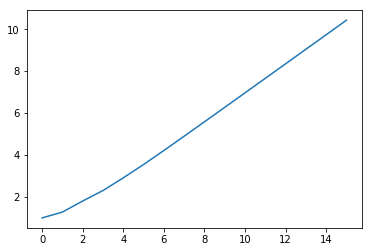

In [46]:
plt.plot(mylr.callback.ws)

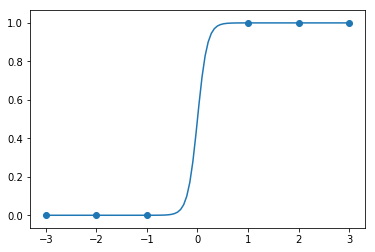

In [47]:
plt.scatter(data2.ravel(), target)
plt.plot(ls, sigmoid(ls*mylr.w))

Попробуем добавить регуляризацию:

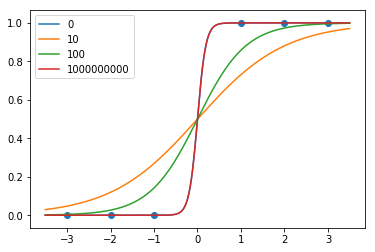

In [48]:
plt.scatter(data2.ravel(), target)
for C in [0, 10, 100, 10**9]:
    mylr = MyLR(C=C)
    mylr.fit(data2, target)
    points = np.linspace(-3.5, 3.5, 1000)
    preds = mylr.predict_proba(points[:, np.newaxis])
    plt.plot(points, preds, label=str(C))
plt.legend()

Нерегуляризованное решение стремится к бесконечным весам (что соответствует аналитическому анализу), регуляризация же решает проблему несуществования решения.

То же на data:

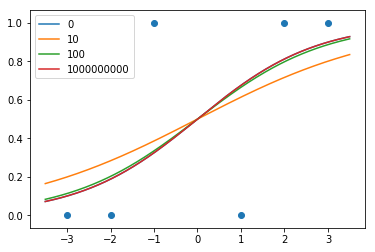

In [49]:
plt.scatter(data.ravel(), target)
for C in [0, 10, 100, 10**9]:
    mylr = MyLR(C=C)
    mylr.fit(data, target)
    points = np.linspace(-3.5, 3.5, 1000)
    preds = mylr.predict_proba(points[:, np.newaxis])
    plt.plot(points, preds, label=str(C))
plt.legend()